### Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

# Load the dataset
df = pd.read_csv('german_credit_data.csv', index_col=0)

# Initial exploration
print(df.head())
print(df.info())
print(df.describe())

# Check target distribution
print("\nTarget variable distribution:")
print(df['Risk'].value_counts(normalize=True))

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   o

In [17]:
# Basic info
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Shape: (1000, 14)

Data Types:
 Age                      int64
Sex                     object
Job                      int64
Housing                 object
Saving accounts         object
Credit amount            int64
Duration                 int64
Risk                     int64
dti                    float64
credit_utilization     float64
age_group             category
purpose_group           object
score                    int64
score_prob             float64
dtype: object

Missing Values:
 Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts       0
Credit amount         0
Duration              0
Risk                  0
dti                   0
credit_utilization    0
age_group             0
purpose_group         0
score                 0
score_prob            0
dtype: int64


### EDA

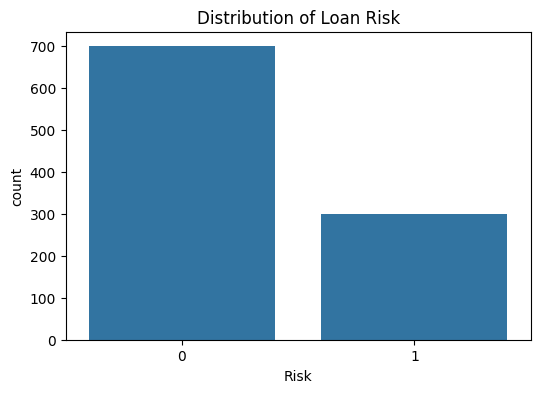

Risk
0    70.0%
1    30.0%
Name: proportion, dtype: object


In [18]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Risk', data=df)
plt.title('Distribution of Loan Risk')
plt.show()

# Percentage breakdown
print(df['Risk'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

               Age  Credit amount     Duration
count  1000.000000    1000.000000  1000.000000
mean     35.546000    3271.258000    20.903000
std      11.375469    2822.736876    12.058814
min      19.000000     250.000000     4.000000
25%      27.000000    1365.500000    12.000000
50%      33.000000    2319.500000    18.000000
75%      42.000000    3972.250000    24.000000
max      75.000000   18424.000000    72.000000


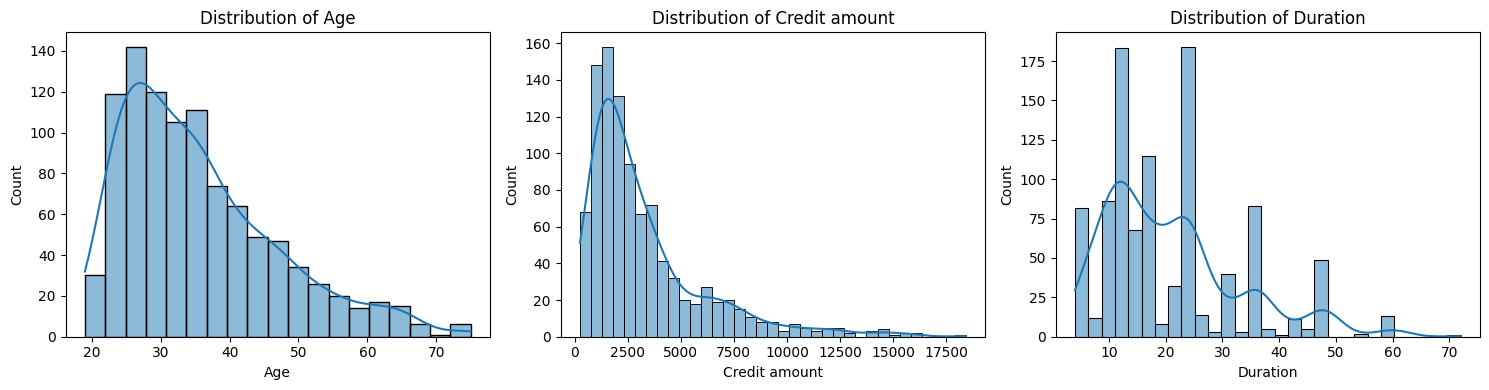

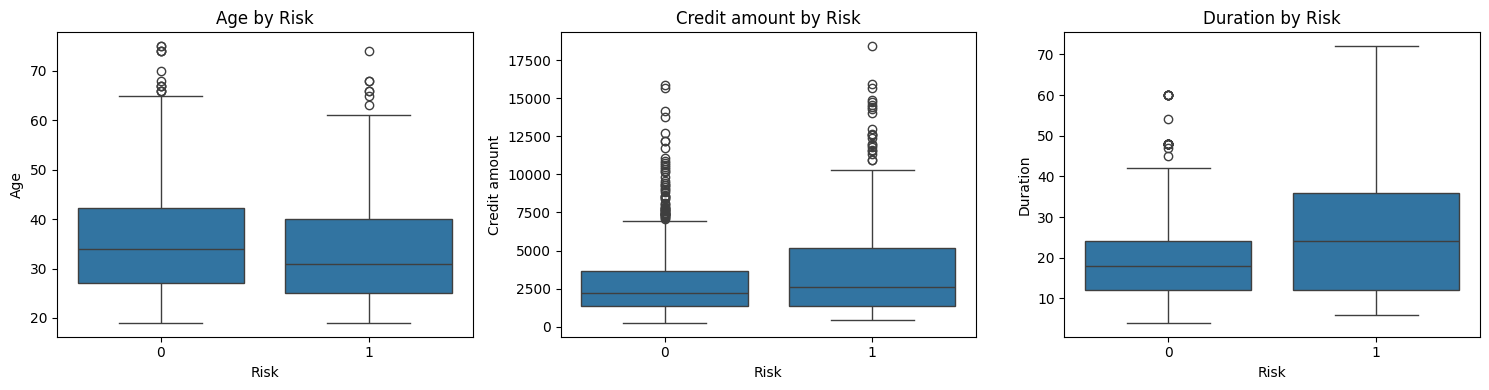

In [23]:
# Select numerical columns
num_cols = ['Age', 'Credit amount', 'Duration']

# Summary stats
print(df[num_cols].describe())

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots by Risk
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(num_cols):
    sns.boxplot(x='Risk', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Risk')
plt.tight_layout()
plt.show()

               Age  Credit amount     Duration
count  1000.000000    1000.000000  1000.000000
mean     35.546000    3271.258000    20.903000
std      11.375469    2822.736876    12.058814
min      19.000000     250.000000     4.000000
25%      27.000000    1365.500000    12.000000
50%      33.000000    2319.500000    18.000000
75%      42.000000    3972.250000    24.000000
max      75.000000   18424.000000    72.000000


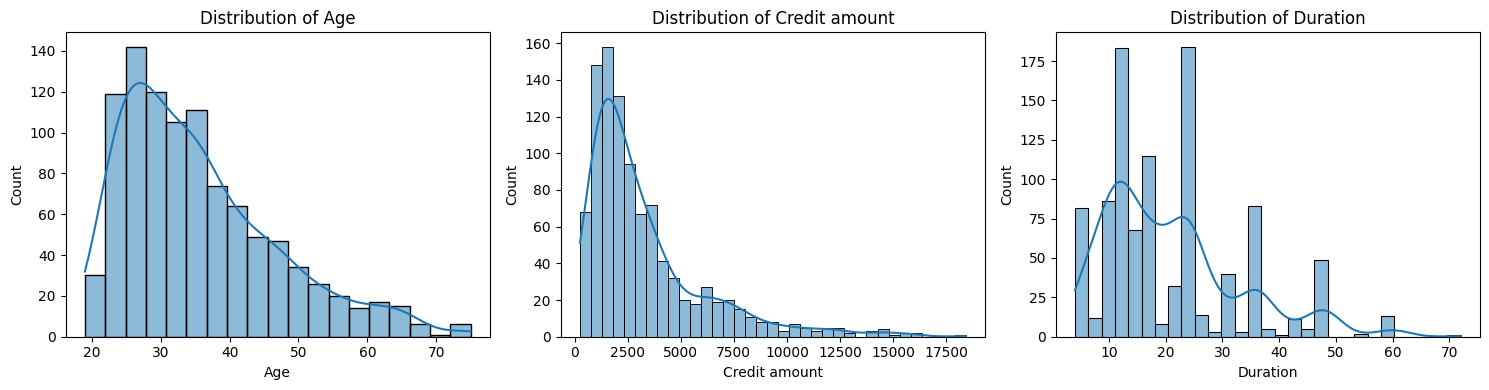

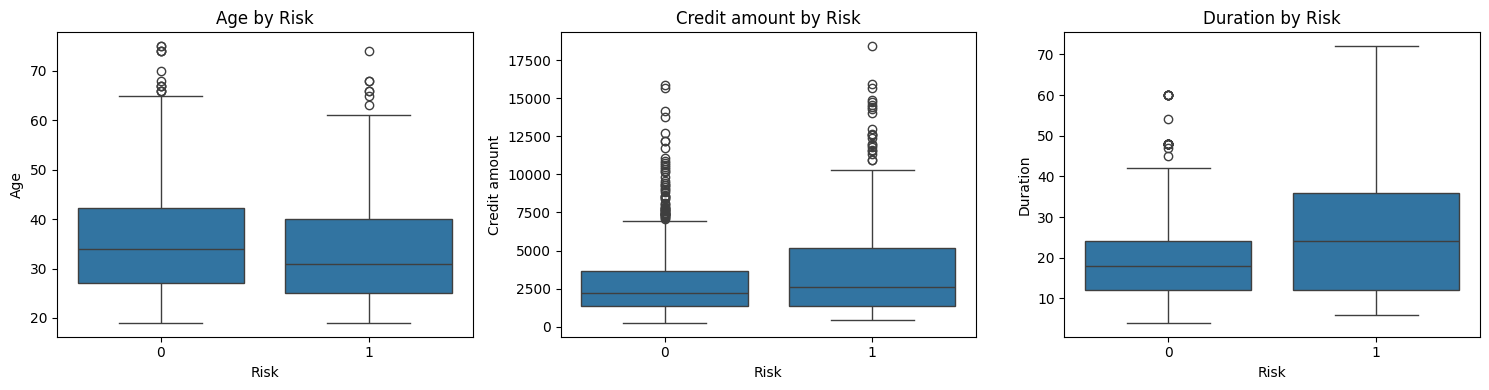

In [24]:
# Select numerical columns
num_cols = ['Age', 'Credit amount', 'Duration']

# Summary stats
print(df[num_cols].describe())

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots by Risk
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(num_cols):
    sns.boxplot(x='Risk', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Risk')
plt.tight_layout()
plt.show()

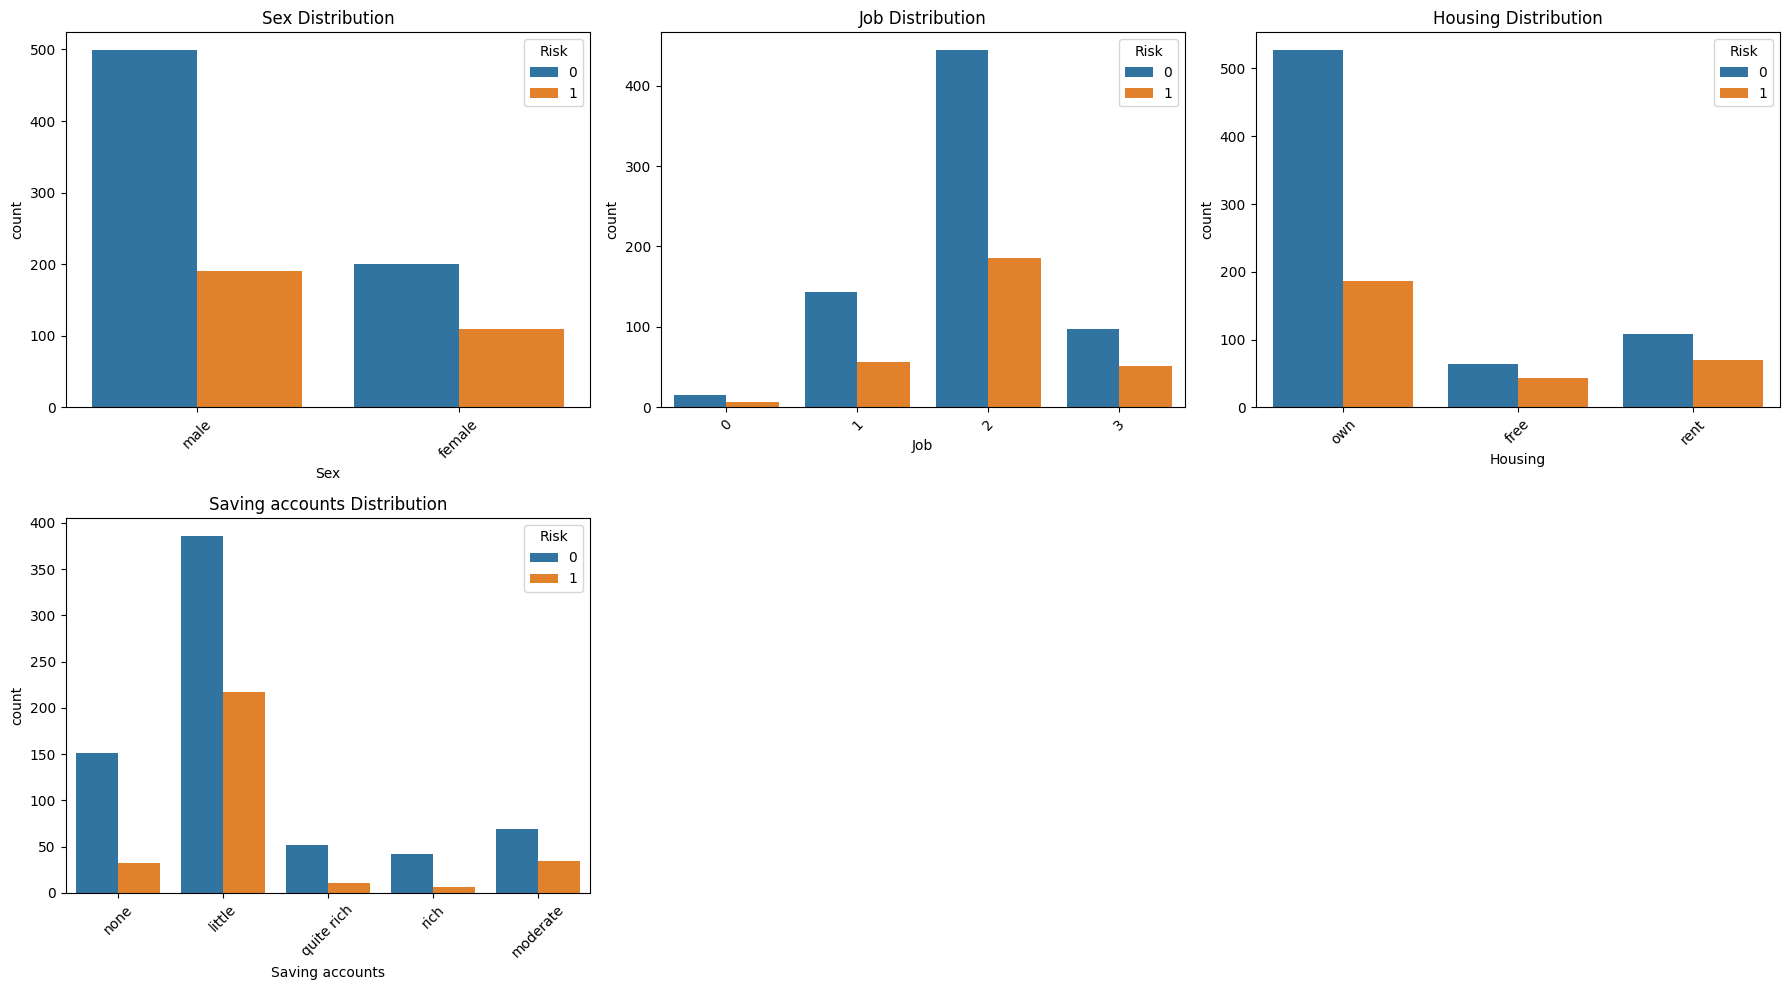


Sex vs Risk:
Risk        0      1
Sex                 
female  64.8%  35.2%
male    72.3%  27.7%

Job vs Risk:
Risk      0      1
Job               
0     68.2%  31.8%
1     72.0%  28.0%
2     70.5%  29.5%
3     65.5%  34.5%

Housing vs Risk:
Risk         0      1
Housing              
free     59.3%  40.7%
own      73.9%  26.1%
rent     60.9%  39.1%

Saving accounts vs Risk:
Risk                 0      1
Saving accounts              
little           64.0%  36.0%
moderate         67.0%  33.0%
none             82.5%  17.5%
quite rich       82.5%  17.5%
rich             87.5%  12.5%


/tmp/ipython-input-26-4101675905.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.crosstab(df[col], df['Risk'], normalize='index').applymap(lambda x: f"{x:.1%}"))
/tmp/ipython-input-26-4101675905.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.crosstab(df[col], df['Risk'], normalize='index').applymap(lambda x: f"{x:.1%}"))
/tmp/ipython-input-26-4101675905.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.crosstab(df[col], df['Risk'], normalize='index').applymap(lambda x: f"{x:.1%}"))
/tmp/ipython-input-26-4101675905.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.crosstab(df[col], df['Risk'], normalize='index').applymap(lambda x: f"{x:.1%}"))


In [26]:
# Use only existing categorical columns
existing_cat_cols = [col for col in ['Sex', 'Job', 'Housing', 'Saving accounts', 'Purpose']
                    if col in df.columns]

# Plot countplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(existing_cat_cols):
    sns.countplot(x=col, hue='Risk', data=df, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for j in range(len(existing_cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Cross-tabulations
for col in existing_cat_cols:
    print(f"\n{col} vs Risk:")
    print(pd.crosstab(df[col], df['Risk'], normalize='index').applymap(lambda x: f"{x:.1%}"))

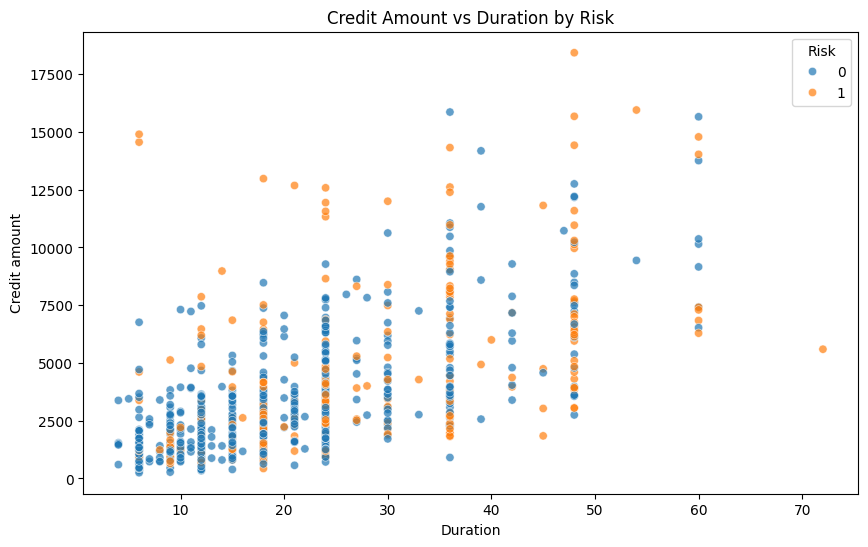

In [22]:
# Credit Amount vs Duration by Risk
plt.figure(figsize=(10,6))
sns.scatterplot(x='Duration', y='Credit amount', hue='Risk', data=df, alpha=0.7)
plt.title('Credit Amount vs Duration by Risk')
plt.show()

### Data Preprocessing and Feature Engineering

In [2]:
# Convert target to binary (1 for bad, 0 for good)
df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})

# Handle missing values
df['Saving accounts'].fillna('none', inplace=True)
df['Checking account'].fillna('none', inplace=True)

# Feature engineering
# Create debt-to-income ratio (assuming Credit amount is annual)
df['dti'] = df['Credit amount'] / (df['Age'] * 1000)  # Simplified approximation

# Create credit utilization feature (simplified)
df['credit_utilization'] = np.where(
    df['Checking account'] == 'none',
    0,
    np.where(df['Checking account'] == 'little', 0.3,
             np.where(df['Checking account'] == 'moderate', 0.6, 0.9))
)

# Create age groups
df['age_group'] = pd.cut(df['Age'],
                         bins=[18, 25, 35, 45, 55, 65, 75],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75'])

# Create purpose groups
df['purpose_group'] = df['Purpose'].apply(lambda x: 'consumption' if x in ['radio/TV', 'furniture/equipment', 'domestic appliances']
                                         else 'transportation' if x == 'car'
                                         else 'education' if x == 'education'
                                         else 'business')

# Drop original columns we've transformed
df.drop(['Checking account', 'Purpose'], axis=1, inplace=True)

# Define categorical and numerical features
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'purpose_group', 'age_group']
numerical_features = ['Age', 'Credit amount', 'Duration', 'dti', 'credit_utilization']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data
X = df.drop('Risk', axis=1)
y = df['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

/tmp/ipython-input-2-1308830302.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Saving accounts'].fillna('none', inplace=True)
/tmp/ipython-input-2-1308830302.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

## Model Building
### Logistic Regression Model

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       140
           1       0.42      0.62      0.50        60

    accuracy                           0.63       200
   macro avg       0.61      0.63      0.60       200
weighted avg       0.68      0.63      0.64       200

ROC AUC: 0.687142857142857


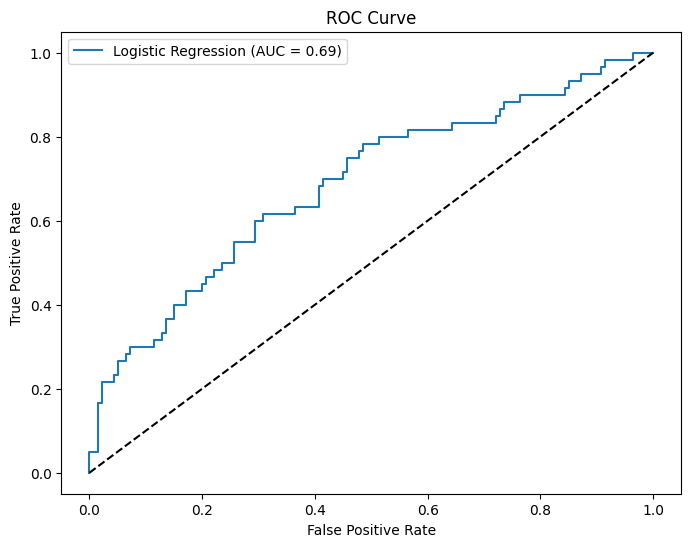

In [3]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train_res, y_train_res)

# Predictions
y_pred_log = log_reg.predict(preprocessor.transform(X_test))
y_pred_proba_log = log_reg.predict_proba(preprocessor.transform(X_test))[:, 1]

# Evaluation
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_log))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_log)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_log):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### LightGBM Model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.836496
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.589385
[LightGBM] [Debug] init for col-wise cost 0.000726 seconds, init for row-wise cost 0.000715 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
Training until validation scores don't improve for 10 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[Light

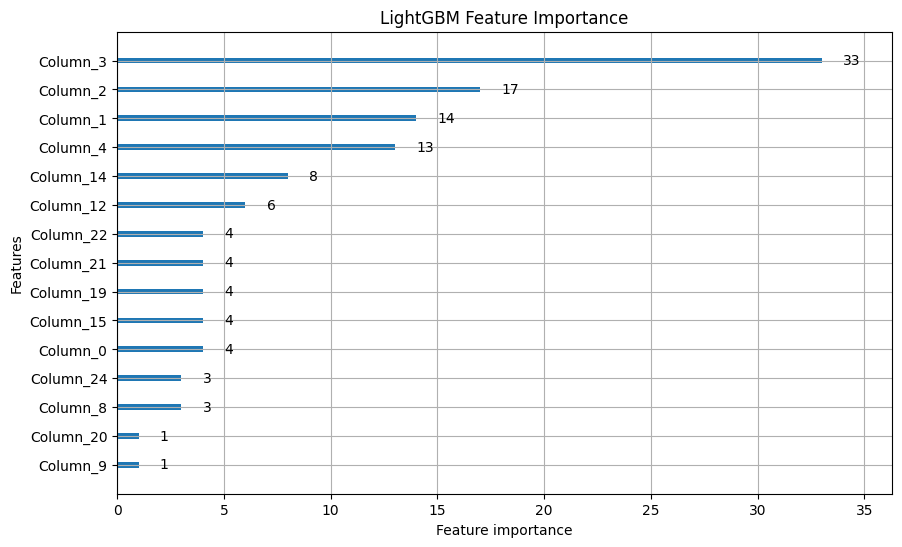

In [6]:
# LightGBM with correct parameter placement
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_estimators=100,
    learning_rate=0.05,
    early_stopping_round=10,  # or early_stopping_rounds depending on your version
    verbose=10  # Move verbose here
)

# Fit the model with eval_set properly formatted
eval_set = [(preprocessor.transform(X_test), y_test)]
lgb_model.fit(
    X_train_res,
    y_train_res,
    eval_set=eval_set,
    eval_metric='auc'
)

# Predictions
y_pred_lgb = lgb_model.predict(preprocessor.transform(X_test))
y_pred_proba_lgb = lgb_model.predict_proba(preprocessor.transform(X_test))[:, 1]

# Evaluation
print("\nLightGBM Results:")
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_lgb))

# Feature Importance
lgb.plot_importance(lgb_model, max_num_features=15, figsize=(10, 6))
plt.title('LightGBM Feature Importance')
plt.show()

### Scorecard Model (Points-Based)

In [9]:
# Scorecard model implementation (simplified)
# This is a basic implementation - real scorecards are more complex

# Calculate WOE (Weight of Evidence) and IV (Information Value)
def calculate_woe_iv(df, feature, target):
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 0)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 1)].count()[feature]
        })
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    return dset, dset['IV'].sum()

# Example for one feature
woe_iv, iv = calculate_woe_iv(df, 'Saving accounts', 'Risk')
print(woe_iv)
print("Information Value:", iv)

# Simple scorecard points assignment (for demonstration)
def simple_scorecard(row):
    score = 300  # base score

    # Age
    if row['Age'] < 25: score -= 20
    elif row['Age'] < 35: score -= 10
    elif row['Age'] < 50: score += 5
    else: score += 10

    # Credit amount
    if row['Credit amount'] < 2000: score += 20
    elif row['Credit amount'] < 5000: score += 10
    else: score -= 10

    # Saving accounts
    if row['Saving accounts'] == 'rich': score += 30
    elif row['Saving accounts'] == 'quite rich': score += 20
    elif row['Saving accounts'] == 'moderate': score += 10
    elif row['Saving accounts'] == 'little': score -= 10
    else: score -= 20

    return score

# Apply scorecard
df['score'] = df.apply(simple_scorecard, axis=1)

# Convert scores to probabilities (simplified)
df['score_prob'] = 1 / 1 + np.exp(-(df['score'] - 500) / 50)

# Evaluate scorecard
print("\nScorecard Results:")
print("ROC AUC:", roc_auc_score(df['Risk'], df['score_prob']))

        Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0        none  183   151   32    0.215714   0.106667  0.704246  0.076796
1      little  603   386  217    0.551429   0.723333 -0.271358  0.046648
2  quite rich   63    52   11    0.074286   0.036667  0.706051  0.026561
3        rich   48    42    6    0.060000   0.020000  1.098612  0.043944
4    moderate  103    69   34    0.098571   0.113333 -0.139552  0.002060
Information Value: 0.1960095569042267

Scorecard Results:
ROC AUC: 0.5906595238095238


### Model Comparison and Selection

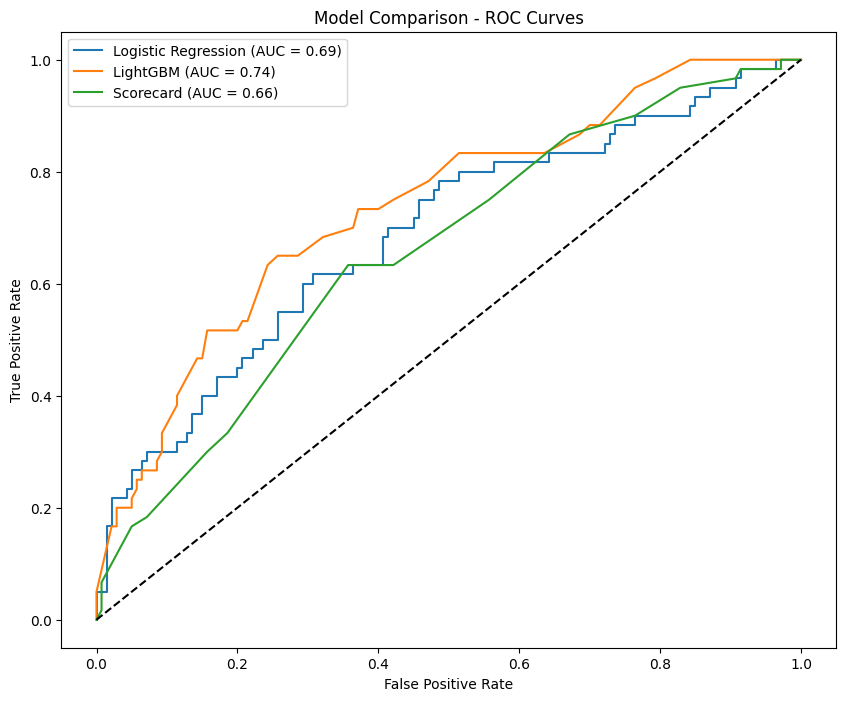

In [10]:
# Compare model performance
models = {
    'Logistic Regression': y_pred_proba_log,
    'LightGBM': y_pred_proba_lgb,
    'Scorecard': df.loc[X_test.index, 'score_prob']
}

plt.figure(figsize=(10, 8))
for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison - ROC Curves')
plt.legend()
plt.show()

# Based on results, LightGBM performs best - let's tune it further

### Hyperparameter Tuning for LightGBM

In [13]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30]
}

lgb_tuned = lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=lgb_tuned, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Final model with best parameters
best_lgb = grid_search.best_estimator_
y_pred_proba_lgb_tuned = best_lgb.predict_proba(preprocessor.transform(X_test))[:, 1]
print("\nTuned LightGBM ROC AUC:", roc_auc_score(y_test, y_pred_proba_lgb_tuned))

[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.845168
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.603476
[LightGBM] [Debug] init for col-wise cost 0.000447 seconds, init for row-wise cost 0.000648 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Probability Calibration

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Number of positive: 373, number of negative: 373
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.855395
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.595940
[LightGBM] [Debug] init for col-wise cost 0.000873 seconds, init for row-wise cost 0.000469 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 746, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[Ligh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Calibrated LightGBM ROC AUC: 0.756547619047619


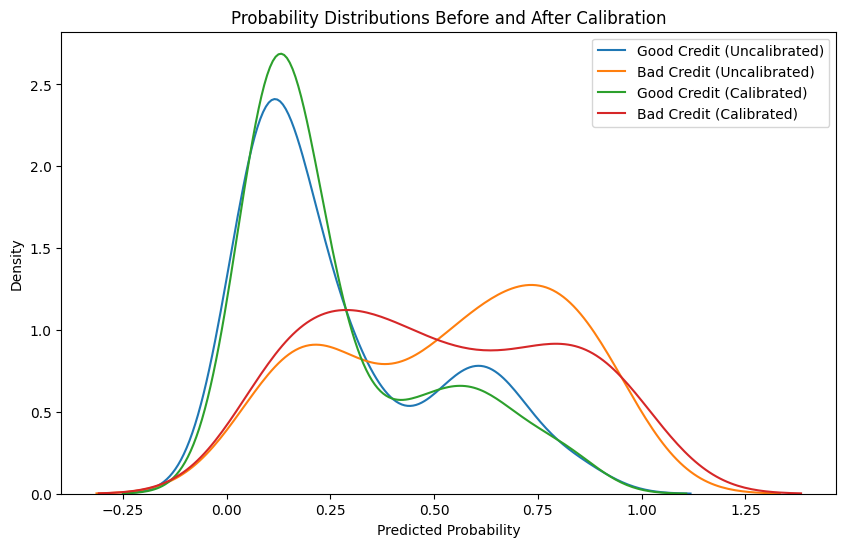

In [16]:
# Calibrate classifier to get better probability estimates
calibrated_lgb = CalibratedClassifierCV(best_lgb, method='isotonic', cv=3)
calibrated_lgb.fit(X_train_res, y_train_res)

y_pred_proba_calibrated = calibrated_lgb.predict_proba(preprocessor.transform(X_test))[:, 1]
print("\nCalibrated LightGBM ROC AUC:", roc_auc_score(y_test, y_pred_proba_calibrated))

# Compare calibrated vs uncalibrated probabilities
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_proba_lgb_tuned[y_test==0], label='Good Credit (Uncalibrated)')
sns.kdeplot(y_pred_proba_lgb_tuned[y_test==1], label='Bad Credit (Uncalibrated)')
sns.kdeplot(y_pred_proba_calibrated[y_test==0], label='Good Credit (Calibrated)')
sns.kdeplot(y_pred_proba_calibrated[y_test==1], label='Bad Credit (Calibrated)')
plt.xlabel('Predicted Probability')
plt.title('Probability Distributions Before and After Calibration')
plt.legend()
plt.show()